# Phase 2 - Inpainting Diffusion

The model is trained to predict the noise \(\epsilon\) using the standard diffusion objective.

Conditioning information is provided via:

- the masked clean image $x_{0,\text{masked}}$
  (context),

- the binary mask $m$ where $m = 1$ indicates pixels that are missing and should be inpainted,

- and the current noisy image $x_t$ at diffusion step $t$.

During sampling, known pixels are clamped after every reverse diffusion step to enforce consistency with the observed image.


What "success" could look like to me:

- Known pixels are exactly preserved (hard clamp)
- Missing region gradually becomes plausible:
  - correct H&E colors
  - compatible morphology with surrounding context
- Early on it may be blurry; that improves with training.

In [1]:
# ============================
# Standard library
# ============================
import os
import random
import shutil
import zipfile
import math
from pathlib import Path
from itertools import product

# ============================
# Scientific / data libraries
# ============================
import numpy as np
import pandas as pd

# ============================
# Visualization
# ============================
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ============================
# Image handling
# ============================
from PIL import Image, ImageFile

# ============================
# PyTorch core
# ============================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ============================
# PyTorch data utilities
# ============================
from torch.utils.data import Dataset, DataLoader

# ============================
# Torchvision
# ============================
from torchvision import transforms
from torchvision.utils import make_grid


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir("drive/MyDrive/Diffusionmodelsforcellimages/")

Mounted at /content/drive/


In [11]:
# Create a DataLoader
class PBCCellDataset(Dataset):
    def __init__(self, root_dir):
        """
        root_dir: path to e.g. 'train/' directory
        """
        self.root_dir = Path(root_dir)

        # Collect all image paths recursively
        self.image_paths = sorted( p for p in self.root_dir.rglob("*.jpg"))

        if len(self.image_paths) == 0:
            raise RuntimeError(f"No images found in {root_dir}")

        self.transform = transforms.Compose([
            #transforms.Resize((64, image_size)),
            #transforms.RandomHorizontalFlip() # it's not really needed for HandE images, cells are roughly rotationally symmetric
            transforms.ToTensor(),                 # scales data to [0, 1]
            transforms.Lambda(lambda t: t * 2 - 1) # scales data to [-1, 1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        x0 = self.transform(img)
        return x0


ds = PBCCellDataset(
    root_dir="data/PBC_dataset_normal_DIB_64x64/")

BATCH_SIZE = 16
dl = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=8,              # 4–8?
    pin_memory=True,
    persistent_workers=True,    # keeps workers alive across epochs
    prefetch_factor=2
)

Define a mask generator (random rectangle). Mask convention:

- mask = 1 for pixels to inpaint (missing)
- mask = 0 for known pixels

In [12]:

def random_rect_mask(batch_size, H, W, min_frac=0.2, max_frac=0.5, device="cpu"):
    """
    Returns mask of shape (B, 1, H, W) with 1 in a random rectangle (missing region).
    """
    masks = torch.zeros((batch_size, 1, H, W), device=device)

    for b in range(batch_size):
        rh = int(random.uniform(min_frac, max_frac) * H)
        rw = int(random.uniform(min_frac, max_frac) * W)

        y0 = random.randint(0, H - rh)
        x0 = random.randint(0, W - rw)

        masks[b, :, y0:y0+rh, x0:x0+rw] = 1.0

    return masks


Here, I am gonna modify the model input channels. Instead of input $x_t$ alone (3 channels), I will feed:

$$
\text{model input} = \operatorname{concat}\left(x_t,\; x_{0,\text{masked}},\; m\right)
$$

where:

- $x_t: (B, 3, H, W)$

- $x_{0,\text{masked}}: (B, 3, H, W)$

- $mask: (B, 1, H, W)$

So, in total: 7 channels

This is a very standard conditioning pattern and tends to be more stable than trying to encode conditioning only by replacing pixels.

In [13]:
# Linear beta schedule; linear noise schedule
def linear_beta_schedule(T, beta_start=1e-4, beta_end=2e-2, device="cpu"):
    betas = torch.linspace(beta_start, beta_end, T, device=device) # define the noise schedule
    alphas = 1.0 - betas # used in reverse updates
    alpha_bars = torch.cumprod(alphas, dim=0) # compute cumulative signal retention; used in both forward diffusion and reverse sampling
    return betas, alphas, alpha_bars

T = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"
betas, alphas, alpha_bars = linear_beta_schedule(T, device=device)

def sinusoidal_time_embedding(timesteps: torch.Tensor, dim: int) -> torch.Tensor:
    """
    Create sinusoidal timestep embeddings.
    IT describes the position of an index in an ordered list.

    Args:
        timesteps: Tensor of shape (B,) containing integer timesteps.
        dim: Dimension of the embedding.

    Returns:
        Tensor of shape (B, dim) with sinusoidal embeddings.
    """
    # Ensure timesteps are floats
    timesteps = timesteps.float()

    device = timesteps.device
    half_dim = dim // 2

    # Compute the frequencies
    exponent = -math.log(10000) / (half_dim - 1)
    frequencies = torch.exp(
        torch.arange(half_dim, device=device) * exponent
    )

    # Outer product: (B, half_dim)
    args = timesteps[:, None] * frequencies[None, :]

    # Sinusoidal embedding
    embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

    # Pad if dim is odd
    if dim % 2 == 1:
        embedding = torch.nn.functional.pad(embedding, (0, 1))

    return embedding


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch) # its' kind of BatchNorm
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_ch)
        )

        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(F.silu(self.norm1(x))) # Silu (that are more common in diffusion models) instead of Relu
        # Add time channel
        h = h + self.time_proj(t_emb)[:, :, None, None]
        h = self.conv2(F.silu(self.norm2(h)))
        return h + self.skip(x)



class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, base_ch=64, time_dim=256):
        super().__init__()
        self.time_dim = time_dim

        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        self.conv_in = nn.Conv2d(in_ch, base_ch, 3, padding=1)

        # Down
        self.rb1 = ResBlock(base_ch, base_ch, time_dim)
        self.down1 = nn.Conv2d(base_ch, base_ch, 4, 2, 1)       # /2

        self.rb2 = ResBlock(base_ch, base_ch*2, time_dim)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*2, 4, 2, 1)   # /4

        self.rb3 = ResBlock(base_ch*2, base_ch*4, time_dim)
        self.down3 = nn.Conv2d(base_ch*4, base_ch*4, 4, 2, 1)   # /8

        # Middle
        self.mid1 = ResBlock(base_ch*4, base_ch*4, time_dim)
        self.mid2 = ResBlock(base_ch*4, base_ch*4, time_dim)

        # Up
        self.up3 = nn.ConvTranspose2d(base_ch*4, base_ch*4, 4, 2, 1)  # x2
        self.urb3 = ResBlock(base_ch*8, base_ch*2, time_dim)

        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch*2, 4, 2, 1)  # x4
        self.urb2 = ResBlock(base_ch*4, base_ch, time_dim)

        self.up1 = nn.ConvTranspose2d(base_ch, base_ch, 4, 2, 1)      # x8
        self.urb1 = ResBlock(base_ch*2, base_ch, time_dim)

        self.conv_out = nn.Sequential(
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, 3, 3, padding=1)
        )

    def forward(self, x, t):
        t_emb = sinusoidal_time_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)

        x0 = self.conv_in(x)
        x1 = self.rb1(x0, t_emb)
        d1 = self.down1(x1)

        x2 = self.rb2(d1, t_emb)
        d2 = self.down2(x2)

        x3 = self.rb3(d2, t_emb)
        d3 = self.down3(x3)

        m = self.mid1(d3, t_emb)
        m = self.mid2(m, t_emb)

        u3 = self.up3(m)
        u3 = torch.cat([u3, x3], dim=1)
        u3 = self.urb3(u3, t_emb)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.urb2(u2, t_emb)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, x1], dim=1)
        u1 = self.urb1(u1, t_emb)

        return self.conv_out(u1)  # predicts epsilon


Change the UNetSmall init:

In [9]:
model = UNetSmall(in_ch=7, base_ch=64, time_dim=256).to(device)

Training loop for inpainting ($ε$-prediction remains unchanged). Key steps per batch:

- Sample a random mask mask
- Create $x_{0,\text{masked}}$ (missing region set to 0 or noise)

Sample timestep $t$:

- Create $x_t$ by forward noising the full $x_0$
- Feed $concat(x_t, x_{0,\text{masked}}, mask)$ into model
- Predict noise and compute MSE loss vs true $ε$


Edit:
To encourage the model to focus on reconstructing the missing regions during inpainting, I use a weighted noise-prediction loss that emphasizes pixels inside the masked area. Specifically, the training objective is defined as

$$
\mathcal{L}
=
\mathbb{E}\Big[
(\hat{\epsilon} - \epsilon)^2 \cdot \big(1 + (w_{\text{missing}} - 1)\, m\big)
\Big],
$$

where $\hat{\epsilon}$ is the model’s predicted noise, $\epsilon$ is the true noise added during the forward diffusion process, \(m\) is a binary mask indicating missing pixels ($m = 1$) versus known pixels ($m = 0$), and $w_{\text{missing}}$ is a scalar hyperparameter controlling the relative importance of the masked region. This weighting scheme increases the contribution of errors inside the missing region while preserving standard noise-prediction training on known pixels, leading to more coherent and structure-aware inpainting results.


In [49]:
Iloss_fn = nn.MSELoss()
opt = optim.AdamW(model.parameters(), lr=2e-4)

# Precompute these once for speed (as I did in Phase 1)
sqrt_alpha_bars = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - alpha_bars)

def q_sample_batch(x0, t, sqrt_alpha_bars, sqrt_one_minus_alpha_bars):
    B = x0.shape[0]
    sa = sqrt_alpha_bars[t].view(B, 1, 1, 1)
    so = sqrt_one_minus_alpha_bars[t].view(B, 1, 1, 1)
    eps = torch.randn_like(x0)
    xt = sa * x0 + so * eps
    return xt, eps

EPOCHS = 30
model.train()

for epoch in range(EPOCHS):
    pbar = tqdm(dl, desc=f"Phase2 epoch {epoch+1}/{EPOCHS}")
    running = 0.0

    for step, x0 in enumerate(pbar):
        x0 = x0.to(device, non_blocking=True)  # (B,3,H,W) in [-1,1]
        B, C, H, W = x0.shape

        # 1) sample mask (1 = missing)
        mask = random_rect_mask(B, H, W, min_frac=0.2, max_frac=0.5, device=device)

        # 2) masked clean context (set missing region to 0)
        x0_masked = x0 * (1.0 - mask)

        # 3) sample t
        t = torch.randint(0, T, (B,), device=device).long()

        # 4) forward diffuse the full x0 -> xt
        xt, eps = q_sample_batch(x0, t, sqrt_alpha_bars, sqrt_one_minus_alpha_bars)

        # 5) model input: concat(xt, x0_masked, mask) -> (B,7,H,W)
        model_in = torch.cat([xt, x0_masked, mask], dim=1)

        # 6) predict noise, compute loss
        eps_hat = model(model_in, t)
        #loss = loss_fn(eps_hat, eps)
        # calcualte weighted loss instead, so missing region contributes ~x× more gradient
        w_missing = 10
        # pixel-wise squared error
        mse = (eps_hat - eps) ** 2  # (B,3,H,W)

        # expand mask to match channels
        mask_c = mask.expand_as(mse)  # (B,3,H,W)

        # weighted loss
        loss = (mse * (1.0 + (w_missing - 1.0) * mask_c)).mean()

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        running += loss.item()
        if step % 50 == 0:
            pbar.set_postfix(loss=running / (step + 1))

    print(f"Epoch {epoch+1} mean loss: {running / len(dl):.4f}")


Phase2 epoch 1/30: 100%|██████████| 602/602 [00:37<00:00, 15.90it/s, loss=0.0205]


Epoch 1 mean loss: 0.0205


Phase2 epoch 2/30: 100%|██████████| 602/602 [00:38<00:00, 15.68it/s, loss=0.0196]


Epoch 2 mean loss: 0.0196


Phase2 epoch 3/30: 100%|██████████| 602/602 [00:38<00:00, 15.47it/s, loss=0.0214]


Epoch 3 mean loss: 0.0214


Phase2 epoch 4/30: 100%|██████████| 602/602 [00:39<00:00, 15.37it/s, loss=0.0212]


Epoch 4 mean loss: 0.0212


Phase2 epoch 5/30: 100%|██████████| 602/602 [00:39<00:00, 15.23it/s, loss=0.02]


Epoch 5 mean loss: 0.0200


Phase2 epoch 6/30: 100%|██████████| 602/602 [00:39<00:00, 15.15it/s, loss=0.0194]


Epoch 6 mean loss: 0.0195


Phase2 epoch 7/30: 100%|██████████| 602/602 [00:39<00:00, 15.09it/s, loss=0.019]


Epoch 7 mean loss: 0.0190


Phase2 epoch 8/30: 100%|██████████| 602/602 [00:40<00:00, 15.05it/s, loss=0.0195]


Epoch 8 mean loss: 0.0195


Phase2 epoch 9/30: 100%|██████████| 602/602 [00:39<00:00, 15.06it/s, loss=0.0221]


Epoch 9 mean loss: 0.0221


Phase2 epoch 10/30: 100%|██████████| 602/602 [00:39<00:00, 15.08it/s, loss=0.019]


Epoch 10 mean loss: 0.0189


Phase2 epoch 11/30: 100%|██████████| 602/602 [00:39<00:00, 15.08it/s, loss=0.0196]


Epoch 11 mean loss: 0.0196


Phase2 epoch 12/30: 100%|██████████| 602/602 [00:39<00:00, 15.08it/s, loss=0.0196]


Epoch 12 mean loss: 0.0196


Phase2 epoch 13/30: 100%|██████████| 602/602 [00:39<00:00, 15.09it/s, loss=0.0198]


Epoch 13 mean loss: 0.0198


Phase2 epoch 14/30: 100%|██████████| 602/602 [00:39<00:00, 15.08it/s, loss=0.0208]


Epoch 14 mean loss: 0.0208


Phase2 epoch 15/30: 100%|██████████| 602/602 [00:39<00:00, 15.05it/s, loss=0.0199]


Epoch 15 mean loss: 0.0198


Phase2 epoch 16/30: 100%|██████████| 602/602 [00:40<00:00, 15.03it/s, loss=0.0177]


Epoch 16 mean loss: 0.0177


Phase2 epoch 17/30: 100%|██████████| 602/602 [00:39<00:00, 15.06it/s, loss=0.0198]


Epoch 17 mean loss: 0.0198


Phase2 epoch 18/30: 100%|██████████| 602/602 [00:39<00:00, 15.06it/s, loss=0.0195]


Epoch 18 mean loss: 0.0196


Phase2 epoch 19/30: 100%|██████████| 602/602 [00:39<00:00, 15.07it/s, loss=0.0195]


Epoch 19 mean loss: 0.0195


Phase2 epoch 20/30: 100%|██████████| 602/602 [00:39<00:00, 15.08it/s, loss=0.0211]


Epoch 20 mean loss: 0.0210


Phase2 epoch 21/30: 100%|██████████| 602/602 [00:39<00:00, 15.09it/s, loss=0.0188]


Epoch 21 mean loss: 0.0188


Phase2 epoch 22/30: 100%|██████████| 602/602 [00:39<00:00, 15.08it/s, loss=0.0193]


Epoch 22 mean loss: 0.0192


Phase2 epoch 23/30: 100%|██████████| 602/602 [00:39<00:00, 15.09it/s, loss=0.0206]


Epoch 23 mean loss: 0.0206


Phase2 epoch 24/30: 100%|██████████| 602/602 [00:39<00:00, 15.11it/s, loss=0.0191]


Epoch 24 mean loss: 0.0192


Phase2 epoch 25/30: 100%|██████████| 602/602 [00:39<00:00, 15.09it/s, loss=0.0206]


Epoch 25 mean loss: 0.0205


Phase2 epoch 26/30: 100%|██████████| 602/602 [00:39<00:00, 15.09it/s, loss=0.0187]


Epoch 26 mean loss: 0.0187


Phase2 epoch 27/30: 100%|██████████| 602/602 [00:39<00:00, 15.09it/s, loss=0.0186]


Epoch 27 mean loss: 0.0185


Phase2 epoch 28/30: 100%|██████████| 602/602 [00:39<00:00, 15.07it/s, loss=0.0185]


Epoch 28 mean loss: 0.0186


Phase2 epoch 29/30: 100%|██████████| 602/602 [00:39<00:00, 15.07it/s, loss=0.0197]


Epoch 29 mean loss: 0.0197


Phase2 epoch 30/30: 100%|██████████| 602/602 [00:39<00:00, 15.08it/s, loss=0.0191]

Epoch 30 mean loss: 0.0191


Inpainting sampling with clamping (the key Phase 2 idea).

We provide a specific image $x0$ and a mask. Then sample starting from noise, and after every reverse step overwrite the known pixels. Clamping rule (hard clamp in normalized space):

- known = 1 - mask
- after each update: $x_t←x_t⋅mask+x_0⋅(1 - mask)$

In [50]:
# alpha_bar_{t-1}
alpha_bars_prev = torch.cat(
    [torch.tensor([1.0], device=device), alpha_bars[:-1]]
)
# posterior variance (DDPM)
posterior_variance = betas * (1.0 - alpha_bars_prev) / (1.0 - alpha_bars)


@torch.no_grad()
def ddpm_inpaint_noised_clamp(
    model, x0, mask,
    T, betas, alphas, alpha_bars, posterior_variance,
    device
):
    model.eval()
    B, C, H, W = x0.shape
    x = torch.randn_like(x0)

    for t in reversed(range(T)):
        t_batch = torch.full((B,), t, device=device, dtype=torch.long)

        # compute the correct known-pixels state at this timestep
        ab = alpha_bars[t]
        eps_known = torch.randn_like(x0)  # fresh noise for known region
        x_known_t = torch.sqrt(ab) * x0 + torch.sqrt(1 - ab) * eps_known

        # clamp known pixels at the correct noise level
        x = x * mask + x_known_t * (1.0 - mask)

        # conditioning (same as training)
        x0_masked = x0 * (1.0 - mask)
        model_in = torch.cat([x, x0_masked, mask], dim=1)

        eps_hat = model(model_in, t_batch)

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        mean = (1.0 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1.0 - alpha_bar_t)) * eps_hat)

        if t > 0:
            z = torch.randn_like(x)
            x = mean + torch.sqrt(posterior_variance[t]) * z
        else:
            x = mean

    # final hard clamp to clean known pixels
    x = x * mask + x0 * (1.0 - mask)
    return x


Visualization before and after

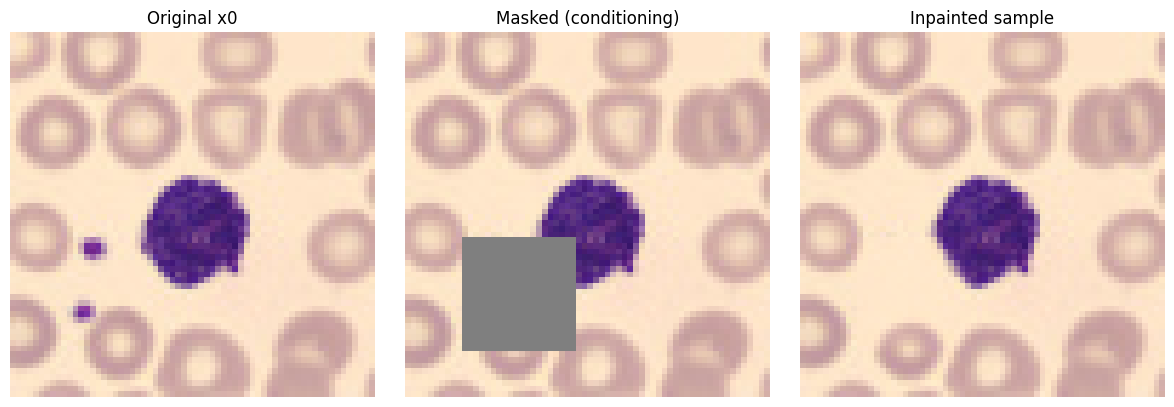

In [55]:
def show_img(x, title=""):
    x = (x.squeeze(0).clamp(-1,1) + 1) / 2  # to [0,1]
    plt.imshow(x.detach().cpu().permute(1,2,0))
    plt.title(title)
    plt.axis("off")

# pick one example
x0 = ds[0].unsqueeze(0).to(device)
B, C, H, W = x0.shape
mask = random_rect_mask(1, H, W, min_frac=0.3, max_frac=0.4, device=device)

x0_masked = x0 * (1.0 - mask)

x_inpaint = ddpm_inpaint(
    model=model,
    x0=x0,
    mask=mask,
    T=T,
    betas=betas,
    alphas=alphas,
    alpha_bars=alpha_bars,
    posterior_variance=posterior_variance,
    device=device
)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); show_img(x0, "Original x0")
plt.subplot(1,3,2); show_img(x0_masked, "Masked (conditioning)")
plt.subplot(1,3,3); show_img(x_inpaint, "Inpainted sample")
plt.tight_layout()
plt.show()


In [57]:
save_path = "checkpoints/phase2_inpaint_unet.pt"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "config": {
            "in_ch": 7,
            "base_ch": 64,
            "time_dim": 256,
            "image_size": 64,
            "T": T,
        },
    },
    save_path
)

print(f"Model saved to {save_path}")


Model saved to checkpoints/phase2_inpaint_unet.pt


In [60]:
!pip install -U onnx onnxruntime onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00


In [61]:
dummy_x = torch.randn(1, 7, 64, 64, device=device)
dummy_t = torch.tensor([10], device=device)

torch.onnx.export(
    model,
    (dummy_x, dummy_t),
    "checkpoints/unet_inpaint.onnx",
    input_names=["x", "t"],
    output_names=["eps_hat"],
    dynamic_axes={
        "x": {0: "batch"},
        "t": {0: "batch"},
        "eps_hat": {0: "batch"},
    },
    opset_version=17,
)


/tmp/ipython-input-704902495.py:4: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1226 18:36:12.109000 1898 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `UNetSmall([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `UNetSmall([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 17 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 17},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"x"<FLOAT,[s13,7,64,64]>,
                %"t"<INT64,[s13]>
            ),
            outputs=(
                %"eps_hat"<FLOAT,[s13,3,64,64]>
            ),
            initializers=(
                %"time_mlp.0.bias"<FLOAT,[256]>{TorchTensor(...)},
                %"time_mlp.2.bias"<FLOAT,[256]>{TorchTensor(...)},
                %"conv_in.bias"<FLOAT,[64]>{TorchTensor(...)},
                %"rb1.conv1.bias"<FLOAT,[64]>{TorchTensor(...)},
                %"rb1.conv2.bias"<FLOAT,[64]>{TorchTensor(...)},
                %"rb1.time_proj.1.bias"<FLOAT,[64]>{TorchTensor(...)},
                %"down1.bias"<FLOAT,[64]>{TorchTensor(...)},
                %"rb2.conv1